# PTQ 与 QAT 实践

本文主要介绍如何使用 PyTorch 将浮点模型转换为 PTQ 或者 QAT 模型。

## 背景

{guilabel}`目标`：快速将浮点模型转换为 PTQ 或者 QAT 模型。

### 读者

本教程适用于会使用 PyTorch 编写 CNN 等模块的的算法工程师。

### 环境配置

本文使用 Python 3.10.0 （其他版本请自测），暂时仅 Linux 平台被测试。

为了提供一致的量化工具接口，我们使用 Python 包 `torchq`。

本地载入临时 `torchq` 包：

In [1]:
from mod import torchq

```{tip}
本文使用 `torchq` 的 `'0.0.1-alpha'` 版本。
```

更方便的是：使用 `pip` 安装：

```shell
pip install torchq==0.0.1-alpha
```

接着，便可以直接导入：

```python
import torchq
```

查看 `torch` 和 `torchvision` 的版本：

In [2]:
import torch
import torchvision

print(f'torch: {torch.__version__} \n'
      f'torchvision: {torchvision.__version__}')

torch: 1.11.0 
torchvision: 0.12.0


设置一些警告配置：

In [3]:
# 设置 warnings
import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning,
    module='.*'
)
warnings.filterwarnings(
    action='ignore',
    module='torch.ao.quantization'
)

## 概述：PQT 与 QAT

参考：[量化](https://pytorch.org/docs/master/quantization.html)

`训练后量化`
:   简称 PTQ（Post Training Quantization）：权重量化，激活量化，需要借助数据在训练后进行校准。

`静态量化感知训练`
:   简称 QAT（static quantization aware training）：权重量化，激活量化，在训练过程中的量化数值进行建模。

`浮点模型`
:   模型的 **权重** 和 **激活** 均为浮点类型（如 {data}`torch.float32`, {data}`torch.float64`）。

`量化模型`
:   模型的 **权重** 和 **激活** 均为量化类型（如 {data}`torch.qint32`, {data}`torch.qint8`, {data}`torch.quint8`, {data}`torch.quint2x4`, {data}`torch.quint4x2`）。


下面举例说明如何将浮点模型转换为量化模型。

为了方便说明定义如下模块：

```{rubric} 定义简单的浮点模块
```

In [4]:
from torch import nn, Tensor


class M(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(1, 1, 1)
        self.relu = torch.nn.ReLU()

    def _forward_impl(self, x: Tensor) -> Tensor:
        '''提供便捷函数'''
        x = self.conv(x)
        x = self.relu(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        x= self._forward_impl(x)
        return x

```{rubric} 定义可量化模型
```

将浮点模块 `M` 转换为可量化模块 `QM`（量化流程的最关键的一步）。

```{rubric} 定义可量化模块
```

In [5]:
from torch.ao.quantization import QuantStub, DeQuantStub


class QM(M):
    '''
    Args:
        is_print: 为了测试需求，打印一些信息
    '''
    def __init__(self, is_print: bool=False):
        super().__init__()
        self.is_print = is_print
        self.quant = QuantStub() # 将张量从浮点转换为量化
        self.dequant = DeQuantStub() # 将张量从量化转换为浮点

    def forward(self, x: Tensor) -> Tensor:
        # 手动指定张量将在量化模型中从浮点模块转换为量化模块的位置
        x = self.quant(x)
        if self.is_print:
            print('量化前的类型：', x.dtype)
        x = self._forward_impl(x)
        if self.is_print:
            print('量化中的类型：',x.dtype)
        # 在量化模型中手动指定张量从量化到浮点的转换位置
        x = self.dequant(x)
        if self.is_print:
            print('量化后的类型：', x.dtype)
        return x

简单测试前向过程的激活数据类型：

In [6]:
input_fp32 = torch.randn(4, 1, 4, 4) # 输入的数据

m = QM(is_print=True)
x = m(input_fp32)

量化前的类型： torch.float32
量化中的类型： torch.float32
量化后的类型： torch.float32


查看权重的数据类型：

In [7]:
m.conv.weight.dtype

torch.float32

可以看出，此时模块 `m` 是浮点模块。

### PTQ 简介

当内存带宽和计算空间都很重要时，通常会使用训练后量化，而 CNN 就是其典型的用例。训练后量化对模型的 **权重** 和 **激活** 进行量化。它在可能的情况下将 **激活** 融合到前面的层中。它需要用具有代表性的数据集进行 **校准**，以确定激活的最佳量化参数。

```{rubric} 示意图
```

```
# 原始模型
# 全部的张量和计算均在浮点上进行
previous_layer_fp32 -- linear_fp32 -- activation_fp32 -- next_layer_fp32
                    /
    linear_weight_fp32

# 静态量化模型
# weights 和 activations 在 int8 上
previous_layer_int8 -- linear_with_activation_int8 -- next_layer_int8
                    /
  linear_weight_int8
```

直接创建浮点模块的实例：

In [8]:
# 创建浮点模型实例
model_fp32 = QM(is_print=True)

要使 PTQ 生效，必须将模型设置为 `eval` 模式：


In [9]:
model_fp32.eval()

QM(
  (conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
  (quant): QuantStub()
  (dequant): DeQuantStub()
)

查看此时的数据类型：

In [10]:
input_fp32 = torch.randn(4, 1, 4, 4)

x = model_fp32(input_fp32)
print('激活和权重的数据类型分别为：'
      f'{x.dtype}, {model_fp32.conv.weight.dtype}')

量化前的类型： torch.float32
量化中的类型： torch.float32
量化后的类型： torch.float32
激活和权重的数据类型分别为：torch.float32, torch.float32


```{rubric} 定义观测器
```

赋值实例变量 `qconfig`，其中包含关于要附加哪种观测器的信息：

- 使用 `'fbgemm'` 进行服务端推理，使用 `'qnnpack'` 进行移动端推理。
- 其他量化配置，如选择对称或非对称量化和 `MinMax` 或 `L2Norm` 校准技术，可以在这里指定。

In [11]:
model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')

查看此时的数据类型：

In [12]:
input_fp32 = torch.randn(4, 1, 4, 4)

x = model_fp32(input_fp32)
print('激活和权重的数据类型分别为：'
      f'{x.dtype}, {model_fp32.conv.weight.dtype}')

量化前的类型： torch.float32
量化中的类型： torch.float32
量化后的类型： torch.float32
激活和权重的数据类型分别为：torch.float32, torch.float32


```{rubric} 融合激活层
```

在适用的地方，融合 activation 到前面的层（这需要根据模型架构手动完成）。常见的融合包括 `conv + relu` 和 `conv + batchnorm + relu`。

In [13]:
model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32,
                                                      [['conv', 'relu']])
                                                    
model_fp32_fused

QM(
  (conv): ConvReLU2d(
    (0): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (relu): Identity()
  (quant): QuantStub()
  (dequant): DeQuantStub()
)

可以看到 `model_fp32_fused` 中 `ConvReLU2d` 融合 `model_fp32` 的两个层 `conv` 和 `relu`。

查看此时的数据类型：

In [14]:
input_fp32 = torch.randn(4, 1, 4, 4)

x = model_fp32_fused(input_fp32)
print('激活和权重的数据类型分别为：'
      f'{x.dtype}, {model_fp32.conv.weight.dtype}')

量化前的类型： torch.float32
量化中的类型： torch.float32
量化后的类型： torch.float32
激活和权重的数据类型分别为：torch.float32, torch.float32


```{rubric} 启用观测器
```

在融合后的模块中启用观测器，用于在校准期间观测激活（activation）张量。

In [15]:
model_fp32_prepared = torch.quantization.prepare(model_fp32_fused)

```{rubric} 校准准备好的模型
```
校准准备好的模型，以确定量化参数的激活在现实世界的设置，校准具有代表性的数据集。

In [16]:
input_fp32 = torch.randn(4, 1, 4, 4)

x = model_fp32_prepared(input_fp32)
print('激活和权重的数据类型分别为：'
      f'{x.dtype}, {model_fp32.conv.weight.dtype}')

量化前的类型： torch.float32
量化中的类型： torch.float32
量化后的类型： torch.float32
激活和权重的数据类型分别为：torch.float32, torch.float32


```{rubric} 模型转换
```

```{note}
量化权重，计算和存储每个激活张量要使用的尺度（scale）和偏差（bias）值，并用量化实现替换关键算子。
```

转换已校准好的模型为量化模型：

In [17]:
model_int8 = torch.quantization.convert(model_fp32_prepared)
model_int8

QM(
  (conv): QuantizedConvReLU2d(1, 1, kernel_size=(1, 1), stride=(1, 1), scale=1.1920928955078125e-07, zero_point=0)
  (relu): Identity()
  (quant): Quantize(scale=tensor([0.0313]), zero_point=tensor([64]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

查看权重的数据类型：

In [18]:
model_int8.conv.weight().dtype

torch.qint8

可以看出此时权重的元素大小为 1 字节，而不是 FP32 的 4 字节：

In [19]:
model_int8.conv.weight().element_size()

1

运行模型，相关的计算将在 {data}`torch.qint8` 中发生。

In [20]:
res = model_int8(input_fp32)
res.dtype

量化前的类型： torch.quint8
量化中的类型： torch.quint8
量化后的类型： torch.float32


torch.float32

要了解更多关于量化意识训练的信息，请参阅 [QAT 教程](https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html)。

### QAT 概述

与其他量化方法相比，QAT 在 **训练过程中** 模拟量化的效果，可以获得更高的 accuracy。在训练过程中，所有的计算都是在浮点上进行的，使用 fake_quant 模块通过夹紧和舍入的方式对量化效果进行建模，模拟 INT8 的效果。模型转换后，权值和激活被量化，激活在可能的情况下被融合到前一层。它通常与 CNN 一起使用，与 PTQ 相比具有更高的 accuracy。


```{rubric} 示意图
```

```
# 原始模型
# 全部张量和计算均在浮点上
previous_layer_fp32 -- linear_fp32 -- activation_fp32 -- next_layer_fp32
                      /
    linear_weight_fp32

# 在训练过程中使用 fake_quants 建模量化数值
previous_layer_fp32 -- fq -- linear_fp32 -- activation_fp32 -- fq -- next_layer_fp32
                           /
   linear_weight_fp32 -- fq

# 量化模型
# weights 和 activations 在 int8 上
previous_layer_int8 -- linear_with_activation_int8 -- next_layer_int8
                     /
   linear_weight_int8
```

定义比 `M` 稍微复杂一点的浮点模块：

In [21]:
class M2(M):
    def __init__(self):
        super().__init__()
        self.bn = torch.nn.BatchNorm2d(1)

    def _forward_impl(self, x: Tensor) -> Tensor:
        '''提供便捷函数'''
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

同样需要定义可量化模块：

In [22]:
class QM2(M2, QM):
    def __init__(self):
        super().__init__()

创建浮点模型实例：

In [23]:
# 创建模型实例
model_fp32 = QM2()
model_fp32

QM2(
  (conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

模型必须设置为训练模式，以便 QAT 可用：

In [24]:
model_fp32.train();

添加量化配置（与 PTQ 相同相似）：

In [25]:
model_fp32.qconfig = torch.ao.quantization.get_default_qat_qconfig('fbgemm')

```{rubric} 融合 QAT 模块
```

QAT 的模块融合与 PTQ 相同相似：

In [26]:
from torch.ao.quantization import fuse_modules_qat

model_fp32_fused = fuse_modules_qat(model_fp32,
                                    [['conv', 'bn', 'relu']])

```{rubric} 准备 QAT 模型
```

这将在模型中插入观测者和伪量化模块，它们将在校准期间观测权重和激活的张量。

In [27]:
model_fp32_prepared = torch.quantization.prepare_qat(model_fp32_fused)

```{rubric} 训练 QAT 模型
```

```python
# 下文会编写实际的例子，此处没有显示
training_loop(model_fp32_prepared)
```

将观测到的模型转换为量化模型。需要：

- 量化权重，计算和存储用于每个激活张量的尺度（scale）和偏差（bias）值，
- 在适当的地方融合模块，并用量化实现替换关键算子。

In [28]:
model_fp32_prepared.eval()
model_int8 = torch.quantization.convert(model_fp32_prepared)

运行模型，相关的计算将在 {data}`torch.qint8` 中发生。

In [29]:
res = model_int8(input_fp32)

要了解更多关于量化意识训练的信息，请参阅 [QAT 教程](https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html)。

### PTQ/QAT 统一的量化流程

PTQ 和 QAT 的量化流程十分相似，为了统一接口，可以使用 `torchvision` 提供的函数 {func}`~torchvision.models.quantization.utils._fuse_modules`。

下面利用函数 {func}`~torchvision.models.quantization.utils._fuse_modules` 可量化模块 `QM2`。

In [30]:
from typing import Any
from torch.ao.quantization import fuse_modules, fuse_modules_qat
from torch.ao.quantization import get_default_qconfig, get_default_qat_qconfig
from torch.ao.quantization import quantize, quantize_qat

def _fuse_modules(
    model: nn.Module, modules_to_fuse: list[str] | list[list[str]], is_qat: bool | None, **kwargs: Any
):
    if is_qat is None:
        is_qat = model.training
    method = fuse_modules_qat if is_qat else fuse_modules
    return method(model, modules_to_fuse, **kwargs)


class QM3(QM2):
    '''可量化模型
    Args:
        is_qat: 是否使用 QAT 模式
    '''
    def __init__(self, is_qat: bool | None = None, backend='fbgemm'):
        super().__init__()
        self.is_qat = is_qat
        # 定义观测器
        if is_qat:
            self.train()
            self.qconfig = get_default_qat_qconfig(backend)
        else:
            self.eval()
            self.qconfig = get_default_qconfig(backend)

    def fuse_model(self) -> None:
        '''模块融合'''
        if self.is_qat:
            modules_to_fuse = ['bn', 'relu']
        else:
            modules_to_fuse = ['conv', 'bn', 'relu']
        return _fuse_modules(self,
                      modules_to_fuse,
                      self.is_qat,
                      inplace=True)

有了可量化模块 `QM3`，可以十分便利的切换 PTQ/QAT了。

比如，PTQ，可以这样：

In [31]:
def run_fn(model, num_epochs):
    for _ in range(num_epochs):
        input_fp32 = torch.randn(4, 1, 4, 4)
        model(input_fp32)

num_epochs = 10
ptq_model = QM3(is_qat=False)
model_fused = ptq_model.fuse_model()
quanted_model = quantize(model_fused, run_fn, [num_epochs])

QAT 可以这样：

In [32]:
num_epochs = 10
qat_model = QM3(is_qat=True)
model_fused = qat_model.fuse_model()
quanted_model = quantize_qat(model_fused, run_fn, [num_epochs])

### PTQ/QAT 量化策略

对于通用量化技术，需要了解：

1. 将任何需要输出再量化请求的运算（因此有额外的参数）从函数形式转换为模块形式（例如，使用 {class}`torch.nn.ReLU` 而不是 {func}`torch.nn.functional.relu`）。
1. 通过在子模块上指定 `.qconfig` 属性或指定 `qconfig_dict` 来指定模型的哪些部分需要量化。例如，设置 `model.conv1.qconfig = None` 表示 `model.conv1` 层不量化，设置 `model.linear1.qconfig = custom_qconfig` 表示 `model.linear1` 将使用 `custom_qconfig` 而不是全局 `qconfig`。

对于量化激活的静态量化技术（即对模型的权重和激活均进行量化，包括 PTQ 和 QAT），用户还需要做以下工作：

1. 指定量化和反量化激活的位置。这是使用 {class}`~torch.ao.quantization.stubs.QuantStub` 和 {class}`~torch.ao.quantization.stubs.DeQuantStub` 模块完成的。
1. 使用 {class}`~torch.nn.quantized.FloatFunctional` 将需要对量化进行特殊处理的张量运算封装到模块中。例如像 {func}`add` 和 {func}`cat` 这样需要特殊处理来确定输出量化参数的运算。
1. 融合模块：将运算/模块组合成单个模块，获得更高的 accuracy 和性能。这是使用 {func}`~torch.ao.quantization.fuse_modules.fuse_modules` API 完成的，该 API 接受要融合的模块列表。目前支持以下融合：`[Conv, Relu]`、 `[Conv, BatchNorm]`、 `[Conv, BatchNorm, Relu]` 和 `[Linear, Relu]`。

下面是倒置残差块的转换对比：

![](images/resnet.png)

## PTQ 和 QAT 实战

可以看出 PTQ 和 QAT 需要用户自定义的内容主要集中在： **模块融合** 和 **算子替换**。

{func}`~torchvision.models.quantization.utils._fuse_modules` 提供了 {func}`~torch.ao.quantization.fuse_modules.fuse_modules` 和 {func}`~torch.ao.quantization.fuse_modules.fuse_modules_qat` 的统一接口。下面以 MobileNetV2 为例，简述如何使用 {func}`~torchvision.models.quantization.utils._fuse_modules` 函数和 {class}`~torch.nn.quantized.FloatFunctional` 类定制可量化的模块。

In [57]:
'''参考 torchvision/models/quantization/mobilenetv2.py
'''
from typing import Any
from torch import Tensor
from torch import nn

from torchvision._internally_replaced_utils import load_state_dict_from_url
from torchvision.ops.misc import ConvNormActivation
from torchvision.models.quantization.utils import _fuse_modules, _replace_relu, quantize_model
from torch.ao.quantization import QuantStub, DeQuantStub
from torchvision.models.mobilenetv2 import InvertedResidual, MobileNetV2, model_urls

quant_model_urls = {
    "mobilenet_v2_qnnpack": "https://download.pytorch.org/models/quantized/mobilenet_v2_qnnpack_37f702c5.pth"
}


class QuantizableInvertedResidual(InvertedResidual):
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        self.skip_add = nn.quantized.FloatFunctional()

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return self.skip_add.add(x, self.conv(x))
        else:
            return self.conv(x)

    def fuse_model(self, is_qat: bool | None = None) -> None:
        for idx in range(len(self.conv)):
            if type(self.conv[idx]) is nn.Conv2d:
                _fuse_modules(self.conv,
                              [str(idx),
                               str(idx + 1)],
                              is_qat,
                              inplace=True)


class QuantizableMobileNetV2(MobileNetV2):
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        """
        MobileNet V2 main class

        Args:
           继承自浮点 MobileNetV2 的参数
        """
        super().__init__(*args, **kwargs)
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def forward(self, x: Tensor) -> Tensor:
        x = self.quant(x)
        x = self._forward_impl(x)
        x = self.dequant(x)
        return x

    def fuse_model(self, is_qat: bool | None=None) -> None:
        for m in self.modules():
            if type(m) is ConvNormActivation:
                _fuse_modules(m, ["0", "1", "2"], is_qat, inplace=True)
            if type(m) is QuantizableInvertedResidual:
                m.fuse_model(is_qat)


def mobilenet_v2(
    pretrained: bool = False,
    progress: bool = True,
    quantize: bool = False,
    **kwargs: Any,
) -> QuantizableMobileNetV2:
    """
    从 `MobileNetV2：反向残差和线性瓶颈 <https://arxiv.org/abs/1801.04381>`_ 构建 MobileNetV2 架构。

    注意，quantize = True 返回具有 8 bit 权值的量化模型。量化模型只支持推理并在 CPU 上运行。
    目前还不支持 GPU 推理

    Args:
        pretrained (bool): 如果为 True，返回在 ImageNet 上训练过的模型。
        progress (bool): 如果为 True，则显示下载到标准错误的进度条
        quantize(bool): 如果为 True，则返回量化模型，否则返回浮点模型
    """
    model = QuantizableMobileNetV2(block=QuantizableInvertedResidual, **kwargs)
    _replace_relu(model)

    if quantize:
        # TODO use pretrained as a string to specify the backend
        backend = "qnnpack"
        quantize_model(model, backend)
    else:
        assert pretrained in [True, False]

    if pretrained:
        if quantize:
            model_url = quant_model_urls["mobilenet_v2_" + backend]
        else:
            model_url = model_urls["mobilenet_v2"]

        state_dict = load_state_dict_from_url(model_url, progress=progress)
        model.load_state_dict(state_dict)
    return model

### 一些准备工作

下面以 Cifar10 为了来说明 PTQ/QAT 的量化流程。

定义几个[辅助函数](https://github.com/pytorch/examples/blob/master/imagenet/main.py)来帮助评估模型。

In [34]:
from torchq.helper import evaluate, print_size_of_model, load_model

设置超参数：

In [35]:
saved_model_dir = 'models/'
float_model_file = 'mobilenet_pretrained_float.pth'
scripted_float_model_file = 'mobilenet_float_scripted.pth'
scripted_ptq_model_file = 'mobilenet_ptq_scripted.pth'
scripted_quantized_model_file = 'mobilenet_quantization_scripted_quantized.pth'
scripted_qat_model_file = 'mobilenet_qat_scripted_quantized.pth'

learning_rate = 5e-5
num_epochs = 30
batch_size = 16
num_classes = 10

# 设置评估策略
criterion = nn.CrossEntropyLoss()

定义数据集和数据加载器：

In [38]:
from torchq.xinet import CV

# 为了 cifar10 匹配 ImageNet，需要将其 resize 到 224
train_iter, test_iter = CV.load_data_cifar10(batch_size=batch_size,
                                             resize=224)

100.0%


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


查看数据集的 batch 次数：

In [39]:
print('训练、测试批次分别为：',
      len(train_iter), len(test_iter))

训练、测试批次分别为： 3125 625


获取训练和测试数据集的大小：

In [40]:
num_train = sum(len(ys) for _, ys in train_iter)
num_eval = sum(len(ys) for _, ys in test_iter)
num_train, num_eval

(50000, 10000)

### 微调浮点模型

配置浮点模型：

In [41]:
#from torchvision.models.quantization import mobilenet_v2

# 定义模型
def create_model(quantize=False,
                 num_classes=10,
                 pretrained=False):
    float_model = mobilenet_v2(pretrained=pretrained,
                               quantize=quantize)
    # 匹配 ``num_classes``
    float_model.classifier[1] = nn.Linear(float_model.last_channel,
                                          num_classes)
    return float_model

定义模型：

In [42]:
float_model = create_model(pretrained=True,
                           quantize=False,
                           num_classes=num_classes)

微调浮点模型：

loss 0.012, train acc 0.996, test acc 0.950
368.7 examples/sec on cuda:2


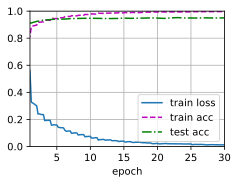

In [43]:
CV.train_fine_tuning(float_model, train_iter, test_iter,
                     learning_rate=learning_rate,
                     num_epochs=num_epochs,
                     device='cuda:2',
                     param_group=True)

保存模型：

In [45]:
torch.save(float_model.state_dict(), saved_model_dir + float_model_file)

### 配置可量化模型

加载浮点模型：

In [46]:
float_model = create_model(quantize=False,
                           num_classes=num_classes)
float_model = load_model(float_model, saved_model_dir + float_model_file)

查看浮点模型的信息：

In [50]:
def print_info(model,
               model_type='浮点模型',
               test_iter=test_iter,
               criterion=criterion, num_eval=num_eval):
    '''打印信息'''
    print_size_of_model(model)
    top1, top5 = evaluate(model, criterion, test_iter)
    print(f'\n{model_type}：\n\t'
          f'在 {num_eval} 张图片上评估 accuracy 为: {top1.avg:2.5f}')

In [51]:
print_info(float_model, model_type='浮点模型')

模型大小：9.187789 MB

浮点模型：
	在 10000 张图片上评估 accuracy 为: 95.00000


可以先查看融合前的 inverted residual 块：

In [52]:
float_model.features[1].conv

Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

融合模块：

In [54]:
float_model.fuse_model(is_qat=None)

查看融合后的 inverted residual 块：

In [55]:
float_model.features[1].conv

Sequential(
  (0): ConvNormActivation(
    (0): ConvReLU2d(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (1): ReLU()
    )
    (1): Identity()
    (2): Identity()
  )
  (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (2): Identity()
)

为了得到“基线”精度，看看融合模块的非量化模型的精度：

In [56]:
model_type = '融合后的浮点模型'
print("baseline 模型大小")
print_size_of_model(float_model)

top1, top5 = evaluate(float_model, criterion, test_iter)

baseline 模型大小
模型大小：8.923757 MB


In [60]:
from torch import jit
print(f'\n{model_type}：\n\t在 {num_eval} 张图片上评估 accuracy 为: {top1.avg:2.2f}')
# 保存
jit.save(jit.script(float_model), saved_model_dir + scripted_float_model_file)


融合后的浮点模型：
	在 10000 张图片上评估 accuracy 为: 95.00


这将是我们进行比较的基准。接下来，尝试不同的量化方法。

### PTQ 实战

In [61]:
# 加载模型
myModel = create_model(pretrained=False,
                       quantize=False,
                       num_classes=num_classes)
float_model = load_model(myModel,
                         saved_model_dir + float_model_file)
myModel.eval()

# 融合
myModel.fuse_model()

指定量化配置（从简单的最小/最大范围估计和加权的逐张量量化开始）：

In [62]:
from torch.ao.quantization.qconfig import default_qconfig

myModel.qconfig = default_qconfig
myModel.qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, quant_min=0, quant_max=127){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){})

开始校准准备：

In [63]:
from torch.ao.quantization.quantize import prepare

print('PTQ 准备：插入观测者')
prepare(myModel, inplace=True)
print('\n 查看观测者插入后的 inverted residual \n\n',
      myModel.features[1].conv)

PTQ 准备：插入观测者

 查看观测者插入后的 inverted residual 

 Sequential(
  (0): ConvNormActivation(
    (0): ConvReLU2d(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (1): ReLU()
      (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
    )
    (1): Identity()
    (2): Identity()
  )
  (1): Conv2d(
    32, 16, kernel_size=(1, 1), stride=(1, 1)
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (2): Identity()
)


用数据集校准：

In [64]:
num_calibration_batches = -1 # 取全部训练集做校准
evaluate(myModel, criterion, train_iter, neval_batches=num_calibration_batches)
print('\nPTQ：校准完成！')


PTQ：校准完成！


转换为量化模型：

In [65]:
from torch.ao.quantization.quantize import convert

convert(myModel, inplace=True)
print('PTQ：转换完成！')

PTQ：转换完成！


融合并量化后，查看融合模块的 Inverted Residual 块：

In [67]:
myModel.features[1].conv

Sequential(
  (0): ConvNormActivation(
    (0): QuantizedConvReLU2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.19337473809719086, zero_point=0, padding=(1, 1), groups=32)
    (1): Identity()
    (2): Identity()
  )
  (1): QuantizedConv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.30905458331108093, zero_point=76)
  (2): Identity()
)

量化后的模型大小：

In [68]:
print_size_of_model(myModel)

模型大小：2.356113 MB


评估：

In [69]:
model_type = 'PTQ 模型'
top1, top5 = evaluate(myModel, criterion, test_iter)
print(f'\n{model_type}：\n\t在 {num_eval} 张图片上评估 accuracy 为: {top1.avg:2.2f}')
jit.save(jit.script(float_model), saved_model_dir + scripted_ptq_model_file)


PTQ 模型：
	在 10000 张图片上评估 accuracy 为: 42.36


使用了简单的 min/max 观测器来确定量化参数，将模型的大小减少到了 2.36 MB 以下，几乎减少了 4 倍。

此外，通过使用不同的量化配置来显著提高精度（对于量化 ARM 架构的推荐配置重复同样的练习）。该配置的操作如下：

- 在 per-channel 基础上量化权重
- 使用直方图观测器，收集激活的直方图，然后以最佳方式选择量化参数。

In [70]:
per_channel_quantized_model = create_model(quantize=False,
                                           num_classes=num_classes)
per_channel_quantized_model = load_model(per_channel_quantized_model,
                                         saved_model_dir + float_model_file)
per_channel_quantized_model.eval()
per_channel_quantized_model.fuse_model()
per_channel_quantized_model.qconfig = get_default_qconfig('fbgemm')
per_channel_quantized_model.qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})

In [71]:
num_calibration_batches = 200 # 仅仅取 200 个批次
prepare(per_channel_quantized_model, inplace=True)
evaluate(per_channel_quantized_model, criterion,
         train_iter, num_calibration_batches)

model_type = 'PTQ 模型（直方图观测器）'
convert(per_channel_quantized_model, inplace=True)
top1, top5 = evaluate(per_channel_quantized_model, criterion, test_iter)

In [72]:
print(f'\n{model_type}：\n\t在 {num_eval} 张图片上评估 accuracy 为: {top1.avg:2.2f}')
jit.save(jit.script(per_channel_quantized_model),
         saved_model_dir + scripted_quantized_model_file)


PTQ 模型（直方图观测器）：
	在 10000 张图片上评估 accuracy 为: 72.39


仅仅改变这种量化配置方法，就可以将准确度提高到 $75.6\%$ 以上！尽管如此，这还是比 $95.09\%$ 的基线水平低了 $19\%$。让我们尝试量化感知训练。

### QAT 实战

使用 QAT，所有的权值和激活都在前向和后向训练过程中被“伪量化”：也就是说，浮点值被舍入以模拟 int8 值，但所有的计算仍然使用浮点数完成。因此，训练过程中的所有权重调整都是在“感知到”模型最终将被量化的情况下进行的；因此，在量化之后，这种方法通常比动态量化或训练后的静态量化产生更高的精度。

实际执行 QAT 的总体工作流程与之前非常相似：

- 可以使用与以前相同的模型：不需要为量化感知训练做额外的准备。
- 需要使用 `qconfig` 来指定在权重和激活之后插入何种类型的伪量化，而不是指定观测者。

In [75]:
def create_qat_model(num_classes,
                     model_path,
                     quantize=False,
                     backend='fbgemm'):
    qat_model = create_model(quantize=quantize,
                             num_classes=num_classes)
    qat_model = load_model(qat_model, model_path)
    qat_model.fuse_model()
    qat_model.qconfig = get_default_qat_qconfig(backend=backend)
    return qat_model

最后，`prepare_qat` 执行“伪量化”，为量化感知训练准备模型：

In [77]:
from torch.ao.quantization.quantize import prepare_qat

model_path = saved_model_dir + float_model_file
qat_model = create_qat_model(num_classes, model_path)
qat_model = prepare_qat(qat_model)

Inverted Residual Block：准备好 QAT 后，注意伪量化模块：

In [78]:
qat_model.features[1].conv

Sequential(
  (0): ConvNormActivation(
    (0): ConvBnReLU2d(
      32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
        (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
      )
      (activation_post_process): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
        (activation_post_process): MovingAver

训练具有高精确度的量化模型要求在推理时对数值进行精确的建模。因此，对于量化感知训练，我们对训练循环进行如下修改：

- 将批处理范数转换为训练结束时的运行均值和方差，以更好地匹配推理数值。
- 冻结量化器参数（尺度和零点）并微调权重。

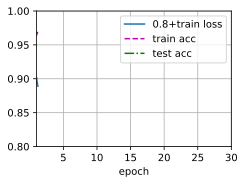

In [79]:
CV.train_fine_tuning(qat_model, train_iter, test_iter,
                     learning_rate=learning_rate,
                     num_epochs=30,
                     device='cuda:2',
                     param_group=True,
                     is_freeze=False,
                     is_quantized_acc=False,
                     need_prepare=False,
                     ylim=[0.8, 1])

```{note}
为了提供更好的视觉效果，这里的损失函数向上平移了 0.8。
```

In [ ]:
convert(qat_model.cpu().eval(), inplace=True)
qat_model.eval();

In [ ]:
print_info(qat_model,'QAT 模型')

量化感知训练在整个 imagenet 数据集上的准确率超过 $94.86\%$，接近浮点精度 $95.09\%$。

更多关于 QAT 的内容：

- QAT 是后训练量化技术的超集，允许更多的调试。例如，我们可以分析模型的准确性是否受到权重或激活量化的限制。
- 也可以在浮点上模拟量化模型的准确性，因为使用伪量化来模拟实际量化算法的数值。
- 也可以很容易地模拟训练后量化。

保存 QAT 模型：

In [ ]:
jit.save(jit.script(qat_model), saved_model_dir + scripted_qat_model_file)